In [1]:
#conda install -c conda-forge eli5 

In [2]:
#conda install -c conda-forge pdpbox

In [3]:
#conda install -c conda-forge shap

In [4]:
import eli5
import pandas as pd
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from eli5.sklearn import PermutationImportance
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot
import category_encoders as ce
from sklearn.metrics import mean_squared_error

In [5]:
PATH = 'C:/Users/Cactuar/Projects/DS-Unit-2-Applied-Modeling/data/caterpillar/caterpillar-tube-pricing/data/competition_data/'

In [6]:
# Read in CSV's
materials = pd.read_csv(PATH + 'bill_of_materials.csv')
components = pd.read_csv(PATH + 'components.csv')
tube = pd.read_csv(PATH + 'tube.csv')
trainval = pd.read_csv(PATH + 'train_set.csv')
test = pd.read_csv(PATH + 'test_set.csv')

In [7]:
# Get tidy data
assemb_comp = materials.melt(id_vars='tube_assembly_id',
                             value_vars=[f'component_id_{n}' for n in range(1,9)])
assemb_comp = (assemb_comp
              .sort_values(by='tube_assembly_id')
              .dropna()
              .rename(columns={'value':'component_id'}))

In [8]:
# Merge tidy data with components
assemb_comp_types = assemb_comp.merge(components, how='left')

In [9]:
# Make a Crosstab of component types
table = pd.crosstab(assemb_comp_types['tube_assembly_id'],
                    assemb_comp_types['component_type_id'])
# reFormat as indexed db
table = table.reset_index()
table.columns.name = '' # removing index name
table.head()

,tube_assembly_id,CP-001,CP-002,CP-003,CP-004,CP-005,CP-006,CP-007,CP-008,CP-009,...,CP-021,CP-022,CP-023,CP-024,CP-025,CP-026,CP-027,CP-028,CP-029,OTHER
0,TA-00001,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
1,TA-00002,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,TA-00003,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,TA-00004,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,TA-00005,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0


In [10]:
# Read in all the comp_ files
comp = pd.concat((pd.read_csv(path) for path in glob(PATH + 'comp_*.csv')), sort=False)

# Select shared features
columns = ['component_id', 'component_type_id', 'orientation', 'unique_feature', 'weight']

# Reshape df with selected columns
comp = comp[columns]

# Binary encode booleans
comp['orientation'] = (comp['orientation']=='Yes').astype(int)
comp['unique_feature'] = (comp['unique_feature']=='Yes').astype(int)
comp['weight'] = comp['weight'].fillna(comp['weight'].median())

In [11]:
# Aggregate components in a tube assembly
materials['components_total'] = sum(materials[f'quantity_{n}'].fillna(0) for n in range(1,9))
materials['components_distinct'] = sum(materials[f'component_id_{n}'].notnull().astype(int) for n in range(1,9))

# Add columns
materials['orientation'] = 0
materials['unique_feature'] = 0
materials['weight'] = 0

In [12]:
# Merge comp & materials then fill nans
for n in range(1,9):
    materials = materials.merge(comp, left_on=f'component_id_{n}', right_on='component_id',
                                how='left', suffixes=('', f'_{n}'))

for col in materials:
    if 'orientation' in col or 'unique_feature' in col or 'weight' in col:
        materials[col] = materials[col].fillna(0)

In [13]:
# select features
features = ['tube_assembly_id', 'orientation', 'unique_feature', 'weight', 
            'components_total', 'components_distinct', 'component_id_1']
materials = materials[features]

In [14]:
# Split trainval into train/val- either or
tv_ta = trainval['tube_assembly_id'].unique()

train_ta, val_ta = train_test_split(tv_ta, random_state=42)

train = trainval[trainval.tube_assembly_id.isin(train_ta)]
val = trainval[trainval.tube_assembly_id.isin(val_ta)]

In [15]:
# wrangle function
def wrangle(X):
    X = X.copy()
    
    # Engineer date features
    X['quote_date'] = pd.to_datetime(X['quote_date'], infer_datetime_format=True)
    X['quote_date_year'] = X['quote_date'].dt.year
    X['quote_date_month'] = X['quote_date'].dt.month
    X = X.drop(columns='quote_date')
    
    # Merge data
    X = (X.merge(table, how='left')
        .merge(materials, how='left')
        .merge(tube, how='left')
        .fillna(0))
    
    # Drop id
    X = X.drop(columns='tube_assembly_id')
    return X

In [16]:
# Wrangle
train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [17]:
# Feature Matrix and target vector
target = 'cost'
X_train = train.drop(columns=target)
X_val = val.drop(columns=target)
X_test = test.drop(columns='id')
y_train = train[target]
y_val = val[target]
y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)

In [18]:
# Encode categorical
encoder = ce.OrdinalEncoder()
Xte = encoder.fit_transform(X_train)
Xve = encoder.transform(X_val)
eval_set = [(Xte, y_train_log), (Xve, y_val_log)]

In [19]:
# Instantiate and fit model
model = XGBRegressor(n_estimators=4000, n_jobs=-1)
model.fit(Xte, y_train_log, eval_set=eval_set, eval_metric='rmse')

[17:11:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.71924	validation_1-rmse:1.70846
[1]	validation_0-rmse:1.56516	validation_1-rmse:1.55498
[2]	validation_0-rmse:1.42779	validation_1-rmse:1.41846
[3]	validation_0-rmse:1.30338	validation_1-rmse:1.2943
[4]	validation_0-rmse:1.19168	validation_1-rmse:1.18295
[5]	validation_0-rmse:1.09322	validation_1-rmse:1.08553
[6]	validation_0-rmse:1.0052	validation_1-rmse:0.997831
[7]	validation_0-rmse:0.927626	validation_1-rmse:0.922043
[8]	validation_0-rmse:0.859812	validation_1-rmse:0.856895
[9]	validation_0-rmse:0.799846	validation_1-rmse:0.798661
[10]	validation_0-rmse:0.747546	validation_1-rmse:0.748466
[11]	validation_0-rmse:0.700748	validation_1-rmse:0.702606
[12]	validation_0-rmse:0.658594	validation_1-rmse:0.661341
[13]	validation_0-rmse:0.623837	validation_1-rmse:0.628781
[14]	validation_0-rmse:0.592662	validation_1-rmse:0.597998
[15]	validation_0-rmse:0

[138]	validation_0-rmse:0.292173	validation_1-rmse:0.320812
[139]	validation_0-rmse:0.291743	validation_1-rmse:0.32062
[140]	validation_0-rmse:0.291596	validation_1-rmse:0.320392
[141]	validation_0-rmse:0.291497	validation_1-rmse:0.320343
[142]	validation_0-rmse:0.290978	validation_1-rmse:0.320039
[143]	validation_0-rmse:0.290277	validation_1-rmse:0.319471
[144]	validation_0-rmse:0.289886	validation_1-rmse:0.319086
[145]	validation_0-rmse:0.289681	validation_1-rmse:0.319029
[146]	validation_0-rmse:0.288404	validation_1-rmse:0.317914
[147]	validation_0-rmse:0.288035	validation_1-rmse:0.317465
[148]	validation_0-rmse:0.287926	validation_1-rmse:0.317171
[149]	validation_0-rmse:0.287594	validation_1-rmse:0.317167
[150]	validation_0-rmse:0.287062	validation_1-rmse:0.31694
[151]	validation_0-rmse:0.286966	validation_1-rmse:0.316882
[152]	validation_0-rmse:0.286235	validation_1-rmse:0.31619
[153]	validation_0-rmse:0.285675	validation_1-rmse:0.315635
[154]	validation_0-rmse:0.285294	validation

[276]	validation_0-rmse:0.258235	validation_1-rmse:0.297997
[277]	validation_0-rmse:0.25813	validation_1-rmse:0.297804
[278]	validation_0-rmse:0.258039	validation_1-rmse:0.297658
[279]	validation_0-rmse:0.25785	validation_1-rmse:0.297555
[280]	validation_0-rmse:0.25758	validation_1-rmse:0.297472
[281]	validation_0-rmse:0.257198	validation_1-rmse:0.297345
[282]	validation_0-rmse:0.256904	validation_1-rmse:0.29729
[283]	validation_0-rmse:0.256759	validation_1-rmse:0.297132
[284]	validation_0-rmse:0.256414	validation_1-rmse:0.296772
[285]	validation_0-rmse:0.256358	validation_1-rmse:0.296727
[286]	validation_0-rmse:0.256289	validation_1-rmse:0.296762
[287]	validation_0-rmse:0.256109	validation_1-rmse:0.296549
[288]	validation_0-rmse:0.255518	validation_1-rmse:0.296067
[289]	validation_0-rmse:0.255237	validation_1-rmse:0.295777
[290]	validation_0-rmse:0.255043	validation_1-rmse:0.295686
[291]	validation_0-rmse:0.254909	validation_1-rmse:0.295596
[292]	validation_0-rmse:0.254664	validation_

[414]	validation_0-rmse:0.238934	validation_1-rmse:0.285367
[415]	validation_0-rmse:0.238902	validation_1-rmse:0.285329
[416]	validation_0-rmse:0.238727	validation_1-rmse:0.285195
[417]	validation_0-rmse:0.238579	validation_1-rmse:0.285162
[418]	validation_0-rmse:0.238388	validation_1-rmse:0.285042
[419]	validation_0-rmse:0.23827	validation_1-rmse:0.28496
[420]	validation_0-rmse:0.238135	validation_1-rmse:0.28488
[421]	validation_0-rmse:0.238079	validation_1-rmse:0.284825
[422]	validation_0-rmse:0.237743	validation_1-rmse:0.284629
[423]	validation_0-rmse:0.237646	validation_1-rmse:0.284452
[424]	validation_0-rmse:0.237587	validation_1-rmse:0.284388
[425]	validation_0-rmse:0.237534	validation_1-rmse:0.284338
[426]	validation_0-rmse:0.237521	validation_1-rmse:0.284332
[427]	validation_0-rmse:0.237184	validation_1-rmse:0.283954
[428]	validation_0-rmse:0.236849	validation_1-rmse:0.283669
[429]	validation_0-rmse:0.23672	validation_1-rmse:0.283536
[430]	validation_0-rmse:0.236605	validation_

[551]	validation_0-rmse:0.224057	validation_1-rmse:0.276796
[552]	validation_0-rmse:0.224012	validation_1-rmse:0.276746
[553]	validation_0-rmse:0.223934	validation_1-rmse:0.276797
[554]	validation_0-rmse:0.223805	validation_1-rmse:0.276707
[555]	validation_0-rmse:0.223738	validation_1-rmse:0.276678
[556]	validation_0-rmse:0.223711	validation_1-rmse:0.276625
[557]	validation_0-rmse:0.223678	validation_1-rmse:0.276574
[558]	validation_0-rmse:0.223639	validation_1-rmse:0.276532
[559]	validation_0-rmse:0.223553	validation_1-rmse:0.276527
[560]	validation_0-rmse:0.223358	validation_1-rmse:0.276488
[561]	validation_0-rmse:0.22331	validation_1-rmse:0.276438
[562]	validation_0-rmse:0.223241	validation_1-rmse:0.276455
[563]	validation_0-rmse:0.223156	validation_1-rmse:0.276463
[564]	validation_0-rmse:0.222985	validation_1-rmse:0.276351
[565]	validation_0-rmse:0.222861	validation_1-rmse:0.276282
[566]	validation_0-rmse:0.222781	validation_1-rmse:0.276228
[567]	validation_0-rmse:0.222712	validati

[689]	validation_0-rmse:0.213439	validation_1-rmse:0.271529
[690]	validation_0-rmse:0.213343	validation_1-rmse:0.271542
[691]	validation_0-rmse:0.213293	validation_1-rmse:0.271571
[692]	validation_0-rmse:0.213252	validation_1-rmse:0.271684
[693]	validation_0-rmse:0.213165	validation_1-rmse:0.271762
[694]	validation_0-rmse:0.213051	validation_1-rmse:0.27142
[695]	validation_0-rmse:0.212992	validation_1-rmse:0.271433
[696]	validation_0-rmse:0.212979	validation_1-rmse:0.27143
[697]	validation_0-rmse:0.212956	validation_1-rmse:0.27145
[698]	validation_0-rmse:0.212875	validation_1-rmse:0.271412
[699]	validation_0-rmse:0.212818	validation_1-rmse:0.2714
[700]	validation_0-rmse:0.212756	validation_1-rmse:0.271296
[701]	validation_0-rmse:0.21272	validation_1-rmse:0.271228
[702]	validation_0-rmse:0.212618	validation_1-rmse:0.271209
[703]	validation_0-rmse:0.212589	validation_1-rmse:0.271192
[704]	validation_0-rmse:0.212556	validation_1-rmse:0.27116
[705]	validation_0-rmse:0.212549	validation_1-r

[827]	validation_0-rmse:0.205845	validation_1-rmse:0.267136
[828]	validation_0-rmse:0.205787	validation_1-rmse:0.267124
[829]	validation_0-rmse:0.205614	validation_1-rmse:0.267117
[830]	validation_0-rmse:0.205559	validation_1-rmse:0.267076
[831]	validation_0-rmse:0.205503	validation_1-rmse:0.266997
[832]	validation_0-rmse:0.205404	validation_1-rmse:0.266918
[833]	validation_0-rmse:0.205354	validation_1-rmse:0.266901
[834]	validation_0-rmse:0.205209	validation_1-rmse:0.266814
[835]	validation_0-rmse:0.205171	validation_1-rmse:0.266867
[836]	validation_0-rmse:0.205082	validation_1-rmse:0.266852
[837]	validation_0-rmse:0.205018	validation_1-rmse:0.266894
[838]	validation_0-rmse:0.20498	validation_1-rmse:0.266906
[839]	validation_0-rmse:0.204913	validation_1-rmse:0.266875
[840]	validation_0-rmse:0.204752	validation_1-rmse:0.266727
[841]	validation_0-rmse:0.204684	validation_1-rmse:0.266709
[842]	validation_0-rmse:0.204619	validation_1-rmse:0.266687
[843]	validation_0-rmse:0.204502	validati

[964]	validation_0-rmse:0.19809	validation_1-rmse:0.264073
[965]	validation_0-rmse:0.198049	validation_1-rmse:0.264092
[966]	validation_0-rmse:0.197998	validation_1-rmse:0.264054
[967]	validation_0-rmse:0.197856	validation_1-rmse:0.264026
[968]	validation_0-rmse:0.197821	validation_1-rmse:0.264041
[969]	validation_0-rmse:0.197798	validation_1-rmse:0.26404
[970]	validation_0-rmse:0.197759	validation_1-rmse:0.263975
[971]	validation_0-rmse:0.197661	validation_1-rmse:0.263933
[972]	validation_0-rmse:0.197599	validation_1-rmse:0.263866
[973]	validation_0-rmse:0.197543	validation_1-rmse:0.263796
[974]	validation_0-rmse:0.197484	validation_1-rmse:0.263719
[975]	validation_0-rmse:0.197394	validation_1-rmse:0.263695
[976]	validation_0-rmse:0.197336	validation_1-rmse:0.263695
[977]	validation_0-rmse:0.197276	validation_1-rmse:0.263656
[978]	validation_0-rmse:0.197204	validation_1-rmse:0.263623
[979]	validation_0-rmse:0.197182	validation_1-rmse:0.263624
[980]	validation_0-rmse:0.197078	validatio

[1100]	validation_0-rmse:0.191639	validation_1-rmse:0.261905
[1101]	validation_0-rmse:0.191613	validation_1-rmse:0.261884
[1102]	validation_0-rmse:0.191547	validation_1-rmse:0.261814
[1103]	validation_0-rmse:0.191513	validation_1-rmse:0.26183
[1104]	validation_0-rmse:0.19148	validation_1-rmse:0.261868
[1105]	validation_0-rmse:0.191445	validation_1-rmse:0.261875
[1106]	validation_0-rmse:0.191432	validation_1-rmse:0.261855
[1107]	validation_0-rmse:0.191424	validation_1-rmse:0.261851
[1108]	validation_0-rmse:0.191422	validation_1-rmse:0.261852
[1109]	validation_0-rmse:0.19141	validation_1-rmse:0.261844
[1110]	validation_0-rmse:0.19137	validation_1-rmse:0.261777
[1111]	validation_0-rmse:0.191279	validation_1-rmse:0.261757
[1112]	validation_0-rmse:0.191227	validation_1-rmse:0.261725
[1113]	validation_0-rmse:0.191196	validation_1-rmse:0.261712
[1114]	validation_0-rmse:0.191155	validation_1-rmse:0.261702
[1115]	validation_0-rmse:0.191127	validation_1-rmse:0.261775
[1116]	validation_0-rmse:0.1

[1235]	validation_0-rmse:0.186248	validation_1-rmse:0.259385
[1236]	validation_0-rmse:0.186183	validation_1-rmse:0.259346
[1237]	validation_0-rmse:0.186132	validation_1-rmse:0.259323
[1238]	validation_0-rmse:0.186088	validation_1-rmse:0.259274
[1239]	validation_0-rmse:0.186052	validation_1-rmse:0.259124
[1240]	validation_0-rmse:0.185993	validation_1-rmse:0.259159
[1241]	validation_0-rmse:0.185965	validation_1-rmse:0.259189
[1242]	validation_0-rmse:0.18593	validation_1-rmse:0.259193
[1243]	validation_0-rmse:0.185928	validation_1-rmse:0.259196
[1244]	validation_0-rmse:0.185837	validation_1-rmse:0.259144
[1245]	validation_0-rmse:0.185793	validation_1-rmse:0.25916
[1246]	validation_0-rmse:0.185745	validation_1-rmse:0.259029
[1247]	validation_0-rmse:0.185677	validation_1-rmse:0.259032
[1248]	validation_0-rmse:0.185653	validation_1-rmse:0.259025
[1249]	validation_0-rmse:0.1856	validation_1-rmse:0.258973
[1250]	validation_0-rmse:0.185558	validation_1-rmse:0.258923
[1251]	validation_0-rmse:0.1

[1370]	validation_0-rmse:0.181427	validation_1-rmse:0.257878
[1371]	validation_0-rmse:0.181421	validation_1-rmse:0.257867
[1372]	validation_0-rmse:0.181386	validation_1-rmse:0.257841
[1373]	validation_0-rmse:0.18135	validation_1-rmse:0.257848
[1374]	validation_0-rmse:0.181298	validation_1-rmse:0.257848
[1375]	validation_0-rmse:0.181238	validation_1-rmse:0.257826
[1376]	validation_0-rmse:0.181226	validation_1-rmse:0.257824
[1377]	validation_0-rmse:0.181189	validation_1-rmse:0.257834
[1378]	validation_0-rmse:0.181185	validation_1-rmse:0.257834
[1379]	validation_0-rmse:0.181171	validation_1-rmse:0.257845
[1380]	validation_0-rmse:0.181154	validation_1-rmse:0.25788
[1381]	validation_0-rmse:0.180978	validation_1-rmse:0.257791
[1382]	validation_0-rmse:0.180946	validation_1-rmse:0.257783
[1383]	validation_0-rmse:0.180927	validation_1-rmse:0.257793
[1384]	validation_0-rmse:0.180912	validation_1-rmse:0.257792
[1385]	validation_0-rmse:0.180883	validation_1-rmse:0.257776
[1386]	validation_0-rmse:0

[1505]	validation_0-rmse:0.177239	validation_1-rmse:0.25681
[1506]	validation_0-rmse:0.177176	validation_1-rmse:0.256778
[1507]	validation_0-rmse:0.177096	validation_1-rmse:0.256756
[1508]	validation_0-rmse:0.177065	validation_1-rmse:0.256772
[1509]	validation_0-rmse:0.177044	validation_1-rmse:0.256796
[1510]	validation_0-rmse:0.177011	validation_1-rmse:0.25677
[1511]	validation_0-rmse:0.177006	validation_1-rmse:0.25677
[1512]	validation_0-rmse:0.176963	validation_1-rmse:0.256744
[1513]	validation_0-rmse:0.176955	validation_1-rmse:0.25673
[1514]	validation_0-rmse:0.176948	validation_1-rmse:0.256719
[1515]	validation_0-rmse:0.176927	validation_1-rmse:0.256711
[1516]	validation_0-rmse:0.176902	validation_1-rmse:0.256665
[1517]	validation_0-rmse:0.176869	validation_1-rmse:0.256649
[1518]	validation_0-rmse:0.176861	validation_1-rmse:0.256649
[1519]	validation_0-rmse:0.176858	validation_1-rmse:0.256648
[1520]	validation_0-rmse:0.176853	validation_1-rmse:0.256643
[1521]	validation_0-rmse:0.1

[1640]	validation_0-rmse:0.173791	validation_1-rmse:0.256036
[1641]	validation_0-rmse:0.173761	validation_1-rmse:0.256
[1642]	validation_0-rmse:0.173746	validation_1-rmse:0.256001
[1643]	validation_0-rmse:0.173726	validation_1-rmse:0.256066
[1644]	validation_0-rmse:0.173698	validation_1-rmse:0.256064
[1645]	validation_0-rmse:0.17366	validation_1-rmse:0.256055
[1646]	validation_0-rmse:0.173599	validation_1-rmse:0.255965
[1647]	validation_0-rmse:0.173563	validation_1-rmse:0.255918
[1648]	validation_0-rmse:0.173541	validation_1-rmse:0.255901
[1649]	validation_0-rmse:0.173525	validation_1-rmse:0.255909
[1650]	validation_0-rmse:0.173504	validation_1-rmse:0.255887
[1651]	validation_0-rmse:0.173499	validation_1-rmse:0.255891
[1652]	validation_0-rmse:0.173486	validation_1-rmse:0.255892
[1653]	validation_0-rmse:0.173474	validation_1-rmse:0.255892
[1654]	validation_0-rmse:0.173405	validation_1-rmse:0.255806
[1655]	validation_0-rmse:0.173355	validation_1-rmse:0.255789
[1656]	validation_0-rmse:0.1

[1775]	validation_0-rmse:0.170136	validation_1-rmse:0.255658
[1776]	validation_0-rmse:0.170132	validation_1-rmse:0.25566
[1777]	validation_0-rmse:0.170124	validation_1-rmse:0.255665
[1778]	validation_0-rmse:0.17007	validation_1-rmse:0.255678
[1779]	validation_0-rmse:0.170039	validation_1-rmse:0.255644
[1780]	validation_0-rmse:0.170008	validation_1-rmse:0.255645
[1781]	validation_0-rmse:0.169991	validation_1-rmse:0.255646
[1782]	validation_0-rmse:0.169979	validation_1-rmse:0.255641
[1783]	validation_0-rmse:0.169948	validation_1-rmse:0.255621
[1784]	validation_0-rmse:0.169903	validation_1-rmse:0.255574
[1785]	validation_0-rmse:0.169883	validation_1-rmse:0.255535
[1786]	validation_0-rmse:0.169853	validation_1-rmse:0.255541
[1787]	validation_0-rmse:0.169822	validation_1-rmse:0.255525
[1788]	validation_0-rmse:0.169798	validation_1-rmse:0.25553
[1789]	validation_0-rmse:0.169795	validation_1-rmse:0.255525
[1790]	validation_0-rmse:0.16977	validation_1-rmse:0.255552
[1791]	validation_0-rmse:0.1

[1910]	validation_0-rmse:0.166859	validation_1-rmse:0.254604
[1911]	validation_0-rmse:0.166843	validation_1-rmse:0.254544
[1912]	validation_0-rmse:0.166812	validation_1-rmse:0.254534
[1913]	validation_0-rmse:0.166777	validation_1-rmse:0.254509
[1914]	validation_0-rmse:0.166731	validation_1-rmse:0.254506
[1915]	validation_0-rmse:0.166711	validation_1-rmse:0.254487
[1916]	validation_0-rmse:0.166697	validation_1-rmse:0.254463
[1917]	validation_0-rmse:0.166691	validation_1-rmse:0.254449
[1918]	validation_0-rmse:0.166642	validation_1-rmse:0.254541
[1919]	validation_0-rmse:0.166528	validation_1-rmse:0.254506
[1920]	validation_0-rmse:0.166517	validation_1-rmse:0.254494
[1921]	validation_0-rmse:0.166512	validation_1-rmse:0.254504
[1922]	validation_0-rmse:0.166492	validation_1-rmse:0.254516
[1923]	validation_0-rmse:0.166475	validation_1-rmse:0.25448
[1924]	validation_0-rmse:0.166431	validation_1-rmse:0.254471
[1925]	validation_0-rmse:0.166403	validation_1-rmse:0.254493
[1926]	validation_0-rmse:

[2045]	validation_0-rmse:0.163306	validation_1-rmse:0.25415
[2046]	validation_0-rmse:0.163276	validation_1-rmse:0.254129
[2047]	validation_0-rmse:0.163257	validation_1-rmse:0.254126
[2048]	validation_0-rmse:0.163245	validation_1-rmse:0.254127
[2049]	validation_0-rmse:0.163214	validation_1-rmse:0.254122
[2050]	validation_0-rmse:0.163198	validation_1-rmse:0.254118
[2051]	validation_0-rmse:0.163196	validation_1-rmse:0.254117
[2052]	validation_0-rmse:0.163194	validation_1-rmse:0.254118
[2053]	validation_0-rmse:0.163155	validation_1-rmse:0.254083
[2054]	validation_0-rmse:0.163138	validation_1-rmse:0.254088
[2055]	validation_0-rmse:0.163127	validation_1-rmse:0.254101
[2056]	validation_0-rmse:0.163111	validation_1-rmse:0.254094
[2057]	validation_0-rmse:0.163102	validation_1-rmse:0.25409
[2058]	validation_0-rmse:0.16307	validation_1-rmse:0.254076
[2059]	validation_0-rmse:0.163052	validation_1-rmse:0.25407
[2060]	validation_0-rmse:0.163044	validation_1-rmse:0.254064
[2061]	validation_0-rmse:0.1

[2180]	validation_0-rmse:0.16058	validation_1-rmse:0.253085
[2181]	validation_0-rmse:0.160559	validation_1-rmse:0.253084
[2182]	validation_0-rmse:0.160551	validation_1-rmse:0.253077
[2183]	validation_0-rmse:0.160526	validation_1-rmse:0.253092
[2184]	validation_0-rmse:0.160498	validation_1-rmse:0.253094
[2185]	validation_0-rmse:0.160474	validation_1-rmse:0.253097
[2186]	validation_0-rmse:0.160444	validation_1-rmse:0.253101
[2187]	validation_0-rmse:0.160438	validation_1-rmse:0.253096
[2188]	validation_0-rmse:0.16043	validation_1-rmse:0.253071
[2189]	validation_0-rmse:0.160429	validation_1-rmse:0.253068
[2190]	validation_0-rmse:0.160406	validation_1-rmse:0.253027
[2191]	validation_0-rmse:0.160383	validation_1-rmse:0.253006
[2192]	validation_0-rmse:0.160347	validation_1-rmse:0.252971
[2193]	validation_0-rmse:0.160322	validation_1-rmse:0.252951
[2194]	validation_0-rmse:0.160311	validation_1-rmse:0.252953
[2195]	validation_0-rmse:0.160289	validation_1-rmse:0.252929
[2196]	validation_0-rmse:0

[2315]	validation_0-rmse:0.157807	validation_1-rmse:0.252547
[2316]	validation_0-rmse:0.157773	validation_1-rmse:0.252564
[2317]	validation_0-rmse:0.157749	validation_1-rmse:0.25253
[2318]	validation_0-rmse:0.15772	validation_1-rmse:0.252474
[2319]	validation_0-rmse:0.157696	validation_1-rmse:0.252484
[2320]	validation_0-rmse:0.157668	validation_1-rmse:0.252481
[2321]	validation_0-rmse:0.157649	validation_1-rmse:0.252473
[2322]	validation_0-rmse:0.157628	validation_1-rmse:0.25251
[2323]	validation_0-rmse:0.157606	validation_1-rmse:0.252473
[2324]	validation_0-rmse:0.157579	validation_1-rmse:0.252499
[2325]	validation_0-rmse:0.157568	validation_1-rmse:0.252497
[2326]	validation_0-rmse:0.157518	validation_1-rmse:0.252463
[2327]	validation_0-rmse:0.157492	validation_1-rmse:0.252465
[2328]	validation_0-rmse:0.157446	validation_1-rmse:0.252449
[2329]	validation_0-rmse:0.157416	validation_1-rmse:0.252464
[2330]	validation_0-rmse:0.157386	validation_1-rmse:0.252459
[2331]	validation_0-rmse:0.

[2450]	validation_0-rmse:0.154603	validation_1-rmse:0.251238
[2451]	validation_0-rmse:0.154578	validation_1-rmse:0.251218
[2452]	validation_0-rmse:0.15455	validation_1-rmse:0.25123
[2453]	validation_0-rmse:0.154541	validation_1-rmse:0.251226
[2454]	validation_0-rmse:0.154518	validation_1-rmse:0.251218
[2455]	validation_0-rmse:0.154516	validation_1-rmse:0.251224
[2456]	validation_0-rmse:0.154508	validation_1-rmse:0.251236
[2457]	validation_0-rmse:0.154483	validation_1-rmse:0.251222
[2458]	validation_0-rmse:0.154472	validation_1-rmse:0.251232
[2459]	validation_0-rmse:0.154462	validation_1-rmse:0.251242
[2460]	validation_0-rmse:0.154449	validation_1-rmse:0.251251
[2461]	validation_0-rmse:0.154444	validation_1-rmse:0.251243
[2462]	validation_0-rmse:0.154398	validation_1-rmse:0.251185
[2463]	validation_0-rmse:0.154379	validation_1-rmse:0.251152
[2464]	validation_0-rmse:0.154344	validation_1-rmse:0.251151
[2465]	validation_0-rmse:0.154321	validation_1-rmse:0.251114
[2466]	validation_0-rmse:0

[2585]	validation_0-rmse:0.152038	validation_1-rmse:0.250373
[2586]	validation_0-rmse:0.152021	validation_1-rmse:0.250357
[2587]	validation_0-rmse:0.152008	validation_1-rmse:0.250349
[2588]	validation_0-rmse:0.151999	validation_1-rmse:0.250344
[2589]	validation_0-rmse:0.151995	validation_1-rmse:0.250346
[2590]	validation_0-rmse:0.151961	validation_1-rmse:0.250434
[2591]	validation_0-rmse:0.15195	validation_1-rmse:0.250421
[2592]	validation_0-rmse:0.151938	validation_1-rmse:0.250438
[2593]	validation_0-rmse:0.151935	validation_1-rmse:0.250439
[2594]	validation_0-rmse:0.151931	validation_1-rmse:0.250437
[2595]	validation_0-rmse:0.151914	validation_1-rmse:0.250423
[2596]	validation_0-rmse:0.151871	validation_1-rmse:0.250378
[2597]	validation_0-rmse:0.151855	validation_1-rmse:0.250378
[2598]	validation_0-rmse:0.151839	validation_1-rmse:0.250371
[2599]	validation_0-rmse:0.151833	validation_1-rmse:0.250392
[2600]	validation_0-rmse:0.151829	validation_1-rmse:0.250392
[2601]	validation_0-rmse:

[2720]	validation_0-rmse:0.150085	validation_1-rmse:0.250489
[2721]	validation_0-rmse:0.150082	validation_1-rmse:0.250476
[2722]	validation_0-rmse:0.150077	validation_1-rmse:0.250485
[2723]	validation_0-rmse:0.150073	validation_1-rmse:0.250484
[2724]	validation_0-rmse:0.150057	validation_1-rmse:0.250459
[2725]	validation_0-rmse:0.150052	validation_1-rmse:0.250449
[2726]	validation_0-rmse:0.150033	validation_1-rmse:0.250442
[2727]	validation_0-rmse:0.150013	validation_1-rmse:0.250478
[2728]	validation_0-rmse:0.149993	validation_1-rmse:0.250484
[2729]	validation_0-rmse:0.149966	validation_1-rmse:0.250486
[2730]	validation_0-rmse:0.149941	validation_1-rmse:0.250526
[2731]	validation_0-rmse:0.149916	validation_1-rmse:0.250524
[2732]	validation_0-rmse:0.149905	validation_1-rmse:0.250522
[2733]	validation_0-rmse:0.149895	validation_1-rmse:0.250516
[2734]	validation_0-rmse:0.149877	validation_1-rmse:0.250525
[2735]	validation_0-rmse:0.149864	validation_1-rmse:0.250542
[2736]	validation_0-rmse

[2855]	validation_0-rmse:0.148236	validation_1-rmse:0.250758
[2856]	validation_0-rmse:0.148233	validation_1-rmse:0.250764
[2857]	validation_0-rmse:0.148216	validation_1-rmse:0.250741
[2858]	validation_0-rmse:0.148214	validation_1-rmse:0.250741
[2859]	validation_0-rmse:0.148207	validation_1-rmse:0.250741
[2860]	validation_0-rmse:0.148206	validation_1-rmse:0.250742
[2861]	validation_0-rmse:0.148177	validation_1-rmse:0.250715
[2862]	validation_0-rmse:0.148175	validation_1-rmse:0.250716
[2863]	validation_0-rmse:0.148151	validation_1-rmse:0.250694
[2864]	validation_0-rmse:0.148147	validation_1-rmse:0.250696
[2865]	validation_0-rmse:0.148144	validation_1-rmse:0.250702
[2866]	validation_0-rmse:0.148141	validation_1-rmse:0.250699
[2867]	validation_0-rmse:0.148135	validation_1-rmse:0.250695
[2868]	validation_0-rmse:0.148114	validation_1-rmse:0.250673
[2869]	validation_0-rmse:0.148098	validation_1-rmse:0.250673
[2870]	validation_0-rmse:0.148092	validation_1-rmse:0.250672
[2871]	validation_0-rmse

[2990]	validation_0-rmse:0.146166	validation_1-rmse:0.250382
[2991]	validation_0-rmse:0.146163	validation_1-rmse:0.250369
[2992]	validation_0-rmse:0.146143	validation_1-rmse:0.250364
[2993]	validation_0-rmse:0.146106	validation_1-rmse:0.250359
[2994]	validation_0-rmse:0.146087	validation_1-rmse:0.250364
[2995]	validation_0-rmse:0.146063	validation_1-rmse:0.250362
[2996]	validation_0-rmse:0.146042	validation_1-rmse:0.250355
[2997]	validation_0-rmse:0.146025	validation_1-rmse:0.250349
[2998]	validation_0-rmse:0.146006	validation_1-rmse:0.250349
[2999]	validation_0-rmse:0.145957	validation_1-rmse:0.250322
[3000]	validation_0-rmse:0.145951	validation_1-rmse:0.250324
[3001]	validation_0-rmse:0.145934	validation_1-rmse:0.250304
[3002]	validation_0-rmse:0.145921	validation_1-rmse:0.25031
[3003]	validation_0-rmse:0.145918	validation_1-rmse:0.25031
[3004]	validation_0-rmse:0.145917	validation_1-rmse:0.250313
[3005]	validation_0-rmse:0.145908	validation_1-rmse:0.250319
[3006]	validation_0-rmse:0

[3125]	validation_0-rmse:0.144153	validation_1-rmse:0.250258
[3126]	validation_0-rmse:0.144151	validation_1-rmse:0.250254
[3127]	validation_0-rmse:0.144133	validation_1-rmse:0.250245
[3128]	validation_0-rmse:0.144133	validation_1-rmse:0.250244
[3129]	validation_0-rmse:0.144107	validation_1-rmse:0.250229
[3130]	validation_0-rmse:0.144093	validation_1-rmse:0.250235
[3131]	validation_0-rmse:0.144083	validation_1-rmse:0.250214
[3132]	validation_0-rmse:0.144071	validation_1-rmse:0.250221
[3133]	validation_0-rmse:0.144066	validation_1-rmse:0.250229
[3134]	validation_0-rmse:0.144047	validation_1-rmse:0.250228
[3135]	validation_0-rmse:0.14403	validation_1-rmse:0.250228
[3136]	validation_0-rmse:0.144018	validation_1-rmse:0.250233
[3137]	validation_0-rmse:0.144006	validation_1-rmse:0.250238
[3138]	validation_0-rmse:0.14397	validation_1-rmse:0.250001
[3139]	validation_0-rmse:0.143955	validation_1-rmse:0.250007
[3140]	validation_0-rmse:0.143928	validation_1-rmse:0.250003
[3141]	validation_0-rmse:0

[3260]	validation_0-rmse:0.142297	validation_1-rmse:0.249707
[3261]	validation_0-rmse:0.142288	validation_1-rmse:0.249712
[3262]	validation_0-rmse:0.142286	validation_1-rmse:0.24971
[3263]	validation_0-rmse:0.142262	validation_1-rmse:0.249692
[3264]	validation_0-rmse:0.142247	validation_1-rmse:0.249693
[3265]	validation_0-rmse:0.14224	validation_1-rmse:0.249686
[3266]	validation_0-rmse:0.142219	validation_1-rmse:0.249668
[3267]	validation_0-rmse:0.142198	validation_1-rmse:0.249672
[3268]	validation_0-rmse:0.142192	validation_1-rmse:0.24967
[3269]	validation_0-rmse:0.142161	validation_1-rmse:0.249671
[3270]	validation_0-rmse:0.142145	validation_1-rmse:0.249679
[3271]	validation_0-rmse:0.142144	validation_1-rmse:0.249671
[3272]	validation_0-rmse:0.142135	validation_1-rmse:0.249671
[3273]	validation_0-rmse:0.142104	validation_1-rmse:0.249678
[3274]	validation_0-rmse:0.142095	validation_1-rmse:0.249686
[3275]	validation_0-rmse:0.142083	validation_1-rmse:0.249681
[3276]	validation_0-rmse:0.

[3395]	validation_0-rmse:0.140317	validation_1-rmse:0.249953
[3396]	validation_0-rmse:0.140291	validation_1-rmse:0.24995
[3397]	validation_0-rmse:0.140272	validation_1-rmse:0.24996
[3398]	validation_0-rmse:0.140262	validation_1-rmse:0.249927
[3399]	validation_0-rmse:0.140246	validation_1-rmse:0.249923
[3400]	validation_0-rmse:0.14022	validation_1-rmse:0.249933
[3401]	validation_0-rmse:0.140198	validation_1-rmse:0.249954
[3402]	validation_0-rmse:0.140187	validation_1-rmse:0.24994
[3403]	validation_0-rmse:0.140184	validation_1-rmse:0.249934
[3404]	validation_0-rmse:0.140145	validation_1-rmse:0.249921
[3405]	validation_0-rmse:0.140135	validation_1-rmse:0.249928
[3406]	validation_0-rmse:0.140112	validation_1-rmse:0.249905
[3407]	validation_0-rmse:0.1401	validation_1-rmse:0.249909
[3408]	validation_0-rmse:0.140064	validation_1-rmse:0.249912
[3409]	validation_0-rmse:0.140049	validation_1-rmse:0.249902
[3410]	validation_0-rmse:0.140038	validation_1-rmse:0.249889
[3411]	validation_0-rmse:0.140

[3530]	validation_0-rmse:0.138241	validation_1-rmse:0.249612
[3531]	validation_0-rmse:0.138239	validation_1-rmse:0.249614
[3532]	validation_0-rmse:0.138226	validation_1-rmse:0.249616
[3533]	validation_0-rmse:0.138222	validation_1-rmse:0.249618
[3534]	validation_0-rmse:0.138208	validation_1-rmse:0.249598
[3535]	validation_0-rmse:0.138199	validation_1-rmse:0.249598
[3536]	validation_0-rmse:0.138183	validation_1-rmse:0.24957
[3537]	validation_0-rmse:0.138181	validation_1-rmse:0.249566
[3538]	validation_0-rmse:0.138166	validation_1-rmse:0.249579
[3539]	validation_0-rmse:0.138148	validation_1-rmse:0.249574
[3540]	validation_0-rmse:0.138136	validation_1-rmse:0.249567
[3541]	validation_0-rmse:0.138116	validation_1-rmse:0.249582
[3542]	validation_0-rmse:0.138111	validation_1-rmse:0.249575
[3543]	validation_0-rmse:0.13811	validation_1-rmse:0.249567
[3544]	validation_0-rmse:0.138109	validation_1-rmse:0.249571
[3545]	validation_0-rmse:0.1381	validation_1-rmse:0.249578
[3546]	validation_0-rmse:0.1

[3665]	validation_0-rmse:0.136679	validation_1-rmse:0.249274
[3666]	validation_0-rmse:0.136678	validation_1-rmse:0.249274
[3667]	validation_0-rmse:0.136677	validation_1-rmse:0.249276
[3668]	validation_0-rmse:0.13667	validation_1-rmse:0.249264
[3669]	validation_0-rmse:0.136651	validation_1-rmse:0.249309
[3670]	validation_0-rmse:0.136634	validation_1-rmse:0.249304
[3671]	validation_0-rmse:0.136622	validation_1-rmse:0.249305
[3672]	validation_0-rmse:0.136621	validation_1-rmse:0.249304
[3673]	validation_0-rmse:0.13662	validation_1-rmse:0.249304
[3674]	validation_0-rmse:0.13662	validation_1-rmse:0.249301
[3675]	validation_0-rmse:0.13661	validation_1-rmse:0.249329
[3676]	validation_0-rmse:0.136596	validation_1-rmse:0.249326
[3677]	validation_0-rmse:0.136577	validation_1-rmse:0.249322
[3678]	validation_0-rmse:0.136559	validation_1-rmse:0.249319
[3679]	validation_0-rmse:0.136549	validation_1-rmse:0.249303
[3680]	validation_0-rmse:0.136528	validation_1-rmse:0.249345
[3681]	validation_0-rmse:0.1

[3800]	validation_0-rmse:0.135289	validation_1-rmse:0.24923
[3801]	validation_0-rmse:0.135282	validation_1-rmse:0.249237
[3802]	validation_0-rmse:0.135249	validation_1-rmse:0.249231
[3803]	validation_0-rmse:0.135233	validation_1-rmse:0.24924
[3804]	validation_0-rmse:0.135225	validation_1-rmse:0.249222
[3805]	validation_0-rmse:0.135217	validation_1-rmse:0.249224
[3806]	validation_0-rmse:0.135195	validation_1-rmse:0.249224
[3807]	validation_0-rmse:0.135192	validation_1-rmse:0.249233
[3808]	validation_0-rmse:0.135181	validation_1-rmse:0.249224
[3809]	validation_0-rmse:0.135177	validation_1-rmse:0.249234
[3810]	validation_0-rmse:0.13516	validation_1-rmse:0.249219
[3811]	validation_0-rmse:0.135144	validation_1-rmse:0.249232
[3812]	validation_0-rmse:0.135142	validation_1-rmse:0.249237
[3813]	validation_0-rmse:0.135135	validation_1-rmse:0.249227
[3814]	validation_0-rmse:0.135126	validation_1-rmse:0.249231
[3815]	validation_0-rmse:0.135112	validation_1-rmse:0.249235
[3816]	validation_0-rmse:0.

[3935]	validation_0-rmse:0.133904	validation_1-rmse:0.249537
[3936]	validation_0-rmse:0.1339	validation_1-rmse:0.249517
[3937]	validation_0-rmse:0.133897	validation_1-rmse:0.249511
[3938]	validation_0-rmse:0.133895	validation_1-rmse:0.249511
[3939]	validation_0-rmse:0.133879	validation_1-rmse:0.249523
[3940]	validation_0-rmse:0.133859	validation_1-rmse:0.249537
[3941]	validation_0-rmse:0.133846	validation_1-rmse:0.249535
[3942]	validation_0-rmse:0.133841	validation_1-rmse:0.24957
[3943]	validation_0-rmse:0.133832	validation_1-rmse:0.249631
[3944]	validation_0-rmse:0.13383	validation_1-rmse:0.249631
[3945]	validation_0-rmse:0.133809	validation_1-rmse:0.24963
[3946]	validation_0-rmse:0.133803	validation_1-rmse:0.249624
[3947]	validation_0-rmse:0.133788	validation_1-rmse:0.249626
[3948]	validation_0-rmse:0.133762	validation_1-rmse:0.249634
[3949]	validation_0-rmse:0.133741	validation_1-rmse:0.249617
[3950]	validation_0-rmse:0.133729	validation_1-rmse:0.249604
[3951]	validation_0-rmse:0.13

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=4000,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

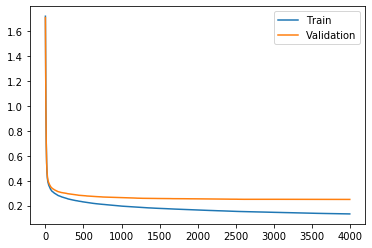

In [20]:
results = model.evals_result()
train_rmse = results['validation_0']['rmse']
val_rmse = results['validation_1']['rmse']
epoch = range(len(train_rmse))
plt.plot(epoch, train_rmse, label='Train')
plt.plot(epoch, val_rmse, label='Validation')
plt.legend();

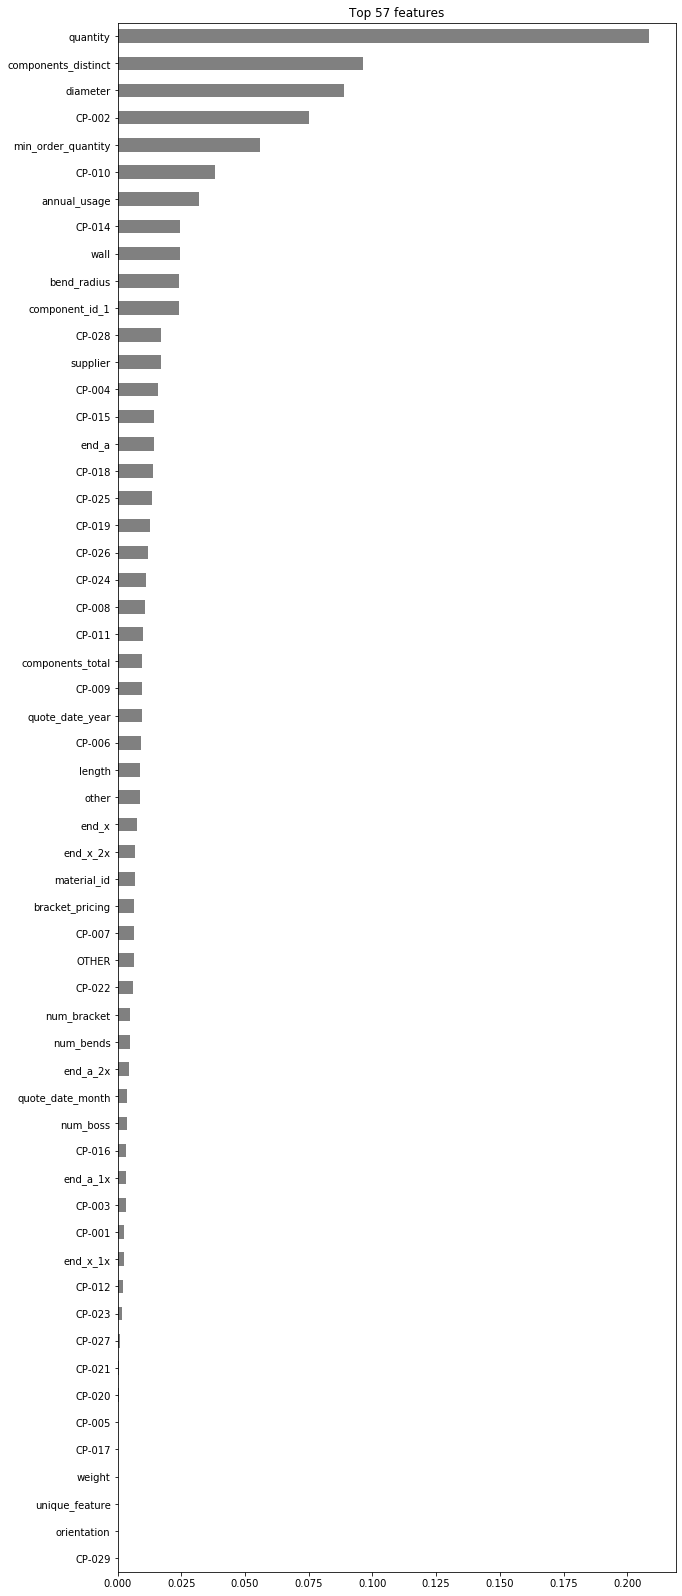

In [21]:
# Get feature imprtances 
importances = pd.Series(model.feature_importances_, Xte.columns)

# Plot feature importances
n = len(Xte.columns)
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

In [22]:
# Permutation Importances
permuter = PermutationImportance(model, scoring='neg_mean_squared_error',
                                 cv ='prefit', n_iter=2, random_state=42)
permuter.fit(Xve, y_val_log)
feature_names = Xve.columns.tolist()
eli5.show_weights(permuter, top=None, feature_names=feature_names)

Weight,Feature
0.7465 ± 0.0055,quantity
0.2729 ± 0.0035,min_order_quantity
0.0816 ± 0.0011,diameter
0.0726 ± 0.0053,supplier
0.0665 ± 0.0019,annual_usage
0.0446 ± 0.0019,quote_date_year
0.0230 ± 0.0032,length
0.0183 ± 0.0008,components_distinct
0.0150 ± 0.0003,wall
0.0134 ± 0.0029,CP-014


In [23]:
# shape before
X_train.shape

(22628, 57)

In [25]:
# Feature Selection by importances
mask = permuter.feature_importances_ > 0.0009
mfeatures = X_train.columns[mask]
X_train = X_train[mfeatures]
X_val = X_val[mfeatures]
X_train.shape

(22628, 35)

In [26]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true,y_pred))

In [27]:
encoder = ce.OrdinalEncoder()
Xte = encoder.fit_transform(X_train)
Xve = encoder.transform(X_val)
model = XGBRegressor(n_estimators=4000, n_jobs=-1)
model.fit(Xte, y_train_log)
y_pred_log = model.predict(Xve)
print(f'Validation RMSLE', rmse(y_val_log, y_pred_log))

[17:14:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Validation RMSLE 0.25394423844560376


(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0xf105e80>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0xfd2cc18>})

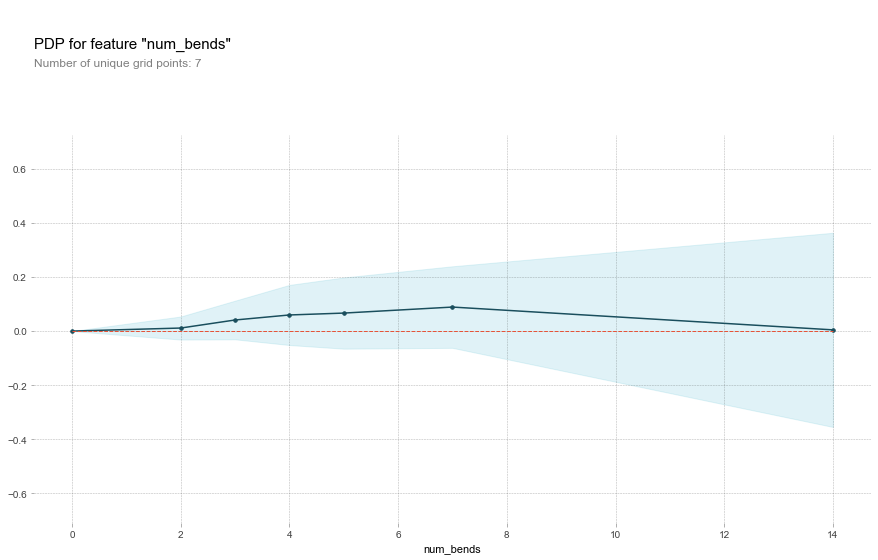

In [28]:
# Partial dependence plot

feature = 'num_bends'
isolated = pdp_isolate(model=model,
                       dataset=Xve,
                       model_features=Xve.columns,
                       feature=feature)
pdp_plot(isolated, feature_name=feature)

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0xfcb5390>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x103f8550>})

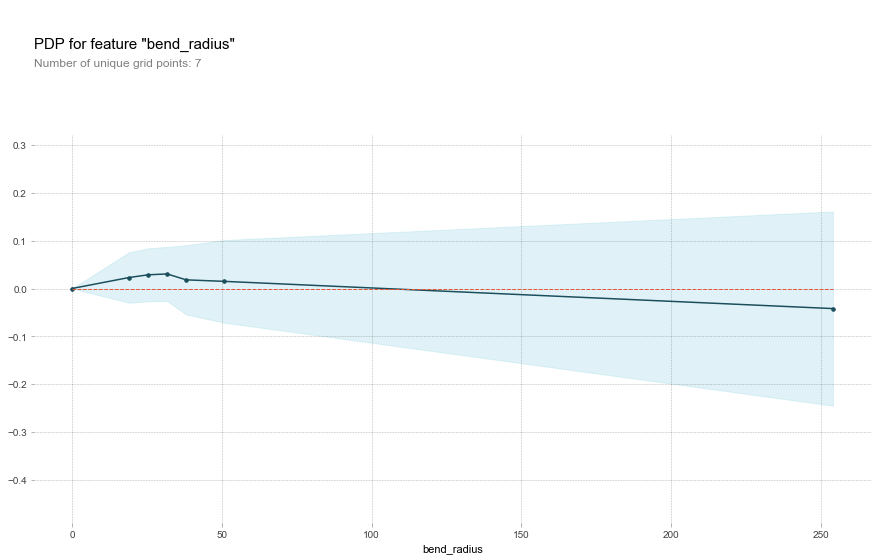

In [29]:
feature = 'bend_radius'
isolated = pdp_isolate(model=model,
                       dataset=Xve,
                       model_features=Xve.columns,
                       feature=feature)
pdp_plot(isolated, feature_name=feature)

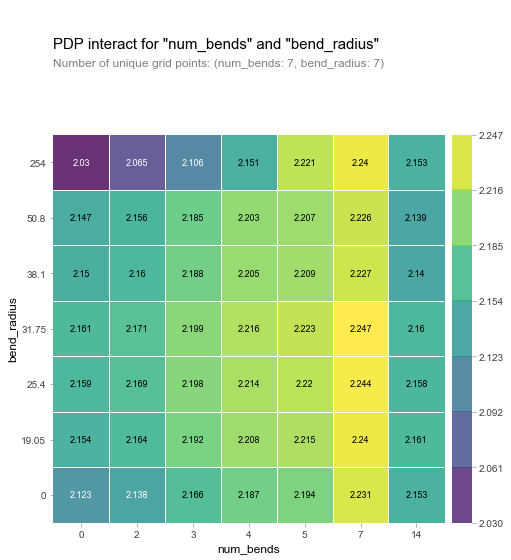

In [30]:
# pdp plot 2 features
features = ['num_bends', 'bend_radius']

interaction = pdp_interact(model=model,
                           dataset=Xve,
                           model_features=Xve.columns,
                           features=features)
pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

In [31]:
import shap

In [34]:
data_to_predict = X_test[X_test.index==1001]
data_to_predict = data_to_predict[mfeatures]
data_to_predictp = encoder.transform(data_to_predict)
data_to_predictp = pd.DataFrame(data_to_predictp)
data_to_predictp.columns = data_to_predict.columns


In [35]:
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(data_to_predictp)
shap.force_plot(explainer.expected_value, shap_values, data_to_predictp)